# plot intensity variance vs nuclear size for 3D images


In [31]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter


anisotropy = (3,1,1) # Relative scale of (Z,X,Y) axes

nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

In [32]:
# on server
raw_input_path = '/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/'
denoised_input_path = raw_input_path+'N2V_1268RG_1273RG/denoised/'
output_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/DPY27/'

if not os.path.exists(output_path+"/plots"):
    os.makedirs(output_path+"/plots")

df=pd.read_csv(output_path+"nuclei_analysis_v001.csv")
df

dist=pd.read_pickle(output_path+"dist_analysis_v001.pkl")
dist



label  bb_dimZ  bb_dimY  bb_dimX  centroid_z  centroid_y  centroid_x  \
0       1        3      332      196   10.237467  450.775726  209.588391   
0       2       13       51       48   17.092244  602.730192  235.823937   
0       3       24       48       58   23.818743  465.149410  405.504229   
0       4       13       47       42   17.885833  526.404655  261.189650   
0       5       10       47       50   16.749367  537.583875  332.809957   
..    ...      ...      ...      ...         ...         ...         ...   
0     176        1       51       38   73.000000  469.446735  300.224055   
0     177        3       50       46   73.961521  519.764720  547.305285   
0     178        2       47       45   74.548074   82.651857  356.528636   
0     179        2       45       47   74.516835  229.001347  541.797306   
0     180        1       15       22   74.000000  542.996255  488.254682   

    major_axis_length  solidity        mean  ...      variance   max  min  \
0          764.512529  0.087499  121.188654  ...     88.081824   148   99   
0           48.632410  0.728521  213.400834  ...   3765.188456   793  105   
0           59.554474  0.738189  227.012229  ...  20523.515241  1047   99   
0           47.890527  0.919311  208.377154  ...  13510.819916   854   99   
0           50.926443  0.926797  179.198181  ...   8683.527708   720   94   
..                ...       ...         ...  ...           ...   ...  ...   
0           57.590836       inf  114.686598  ...    118.517587   178   93   
0           50.847402  0.832176  122.205610  ...    214.551837   200   94   
0           50.134214  0.929655  123.495314  ...    216.375629   184   93   
0           51.816379  0.942857  117.805724  ...     84.190876   154   92   
0           25.059204       inf  117.449438  ...     92.142575   148   89   

    volume                                    id  \
0      758    DPY27_3d_20240915_1268_E_bean_15um   
0    11990    DPY27_3d_20240915_1268_E_bean_15um   
0    26250    DPY27_3d_20240915_1268_E_bean_15um   
0    15381    DPY27_3d_20240915_1268_E_bean_15um   
0    14623    DPY27_3d_20240915_1268_E_bean_15um   
..     ...                                   ...   
0     1455  DPY27_3d_20240915_1268_E_mid_15um_08   
0     4314  DPY27_3d_20240915_1268_E_mid_15um_08   
0     2881  DPY27_3d_20240915_1268_E_mid_15um_08   
0     2970  DPY27_3d_20240915_1268_E_mid_15um_08   
0      267  DPY27_3d_20240915_1268_E_mid_15um_08   

                                intensity_dist_nuclei  \
0                                                  []   
0   [134.06474820143885, 140.66141732283464, 144.1...   
0   [136.09174311926606, 135.79, 137.9076923076923...   
0   [140.14110429447854, 143.66883116883116, 147.5...   
0   [131.55307262569832, 138.69398907103826, 144.7...   
..                                                ...   
0   [107.13333333333334, 108.28481012658227, 106.0...   
0   [107.68518518518519, 107.77852348993288, 108.7...   
0   [107.45238095238095, 108.55367231638418, 106.8...   
0   [108.29239766081871, 108.7202380952381, 107.73...   
0   [108.52941176470588, 107.45098039215686, 105.2...   

                                 intensity_dist_spots  \
0                                                  []   
0   [202.6043165467626, 217.77165354330708, 231.94...   
0   [188.52293577981652, 201.32, 206.5692307692307...   
0   [154.62576687116564, 148.98701298701297, 152.5...   
0   [127.77094972067039, 130.05464480874318, 134.2...   
..                                                ...   
0   [114.71333333333334, 116.55696202531645, 117.1...   
0   [126.17283950617283, 124.60402684563758, 122.2...   
0   [114.17857142857143, 116.12429378531074, 117.2...   
0   [117.21052631578948, 118.77380952380952, 118.6...   
0   [116.94117647058823, 115.50980392156863, 117.4...   

                                       intensity_dist  \
0                                                  []   
0     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   


## Add some variables
Radius might scale more linearly than volume
Coefficient of variation is independent of the mean signal

In [33]:
def radiusFromVolume(volume):
    return (3*volume/(4*np.pi))**(1/3)

def coefficientOfVariation(std,mean):
    return std/mean


df['radius'] = radiusFromVolume(df['volume'])
df['cv'] = coefficientOfVariation(df['std'],df['mean'])
df['zx_ratio'] = df['bb_dimZ']/df['bb_dimX']
df['zy_ratio'] = df['bb_dimZ']/df['bb_dimY']
df['xy_ratio'] = df['bb_dimX']/df['bb_dimY']

df=df.merge(dist[['id','label','zproj_spots','zproj_nuclei']],on=['id','label'])
df
#sns.scatterplot(data=df, x="volume", y="radius")
#sns.scatterplot(data=df, x="mean", y="std")
#sns.scatterplot(data=df, x="mean", y="cv")

label  bb_dimZ  bb_dimY  bb_dimX  centroid_z  centroid_y  centroid_x  \
0         1        3      332      196   10.237467  450.775726  209.588391   
1         2       13       51       48   17.092244  602.730192  235.823937   
2         3       24       48       58   23.818743  465.149410  405.504229   
3         4       13       47       42   17.885833  526.404655  261.189650   
4         5       10       47       50   16.749367  537.583875  332.809957   
...     ...      ...      ...      ...         ...         ...         ...   
4629    176        1       51       38   73.000000  469.446735  300.224055   
4630    177        3       50       46   73.961521  519.764720  547.305285   
4631    178        2       47       45   74.548074   82.651857  356.528636   
4632    179        2       45       47   74.516835  229.001347  541.797306   
4633    180        1       15       22   74.000000  542.996255  488.254682   

      major_axis_length  solidity        mean  ...  protein  \
0            764.512529  0.087499  121.188654  ...    DPY27   
1             48.632410  0.728521  213.400834  ...    DPY27   
2             59.554474  0.738189  227.012229  ...    DPY27   
3             47.890527  0.919311  208.377154  ...    DPY27   
4             50.926443  0.926797  179.198181  ...    DPY27   
...                 ...       ...         ...  ...      ...   
4629          57.590836       inf  114.686598  ...    DPY27   
4630          50.847402  0.832176  122.205610  ...    DPY27   
4631          50.134214  0.929655  123.495314  ...    DPY27   
4632          51.816379  0.942857  117.805724  ...    DPY27   
4633          25.059204       inf  117.449438  ...    DPY27   

                                           raw_filepath  \
0     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
1     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
2     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
3     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
...                                                 ...   
4629  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4630  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4631  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4632  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4633  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   

                                      denoised_filepath     radius        cv  \
0     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   5.656227  0.077443   
1     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  14.198535  0.287539   
2     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  18.436575  0.631069   
3     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  15.427610  0.557816   
4     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  15.169897  0.520013   
...                                                 ...        ...       ...   
4629  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   7.029506  0.094925   
4630  /mnt/external.data/MeisterLab/Dario/Imaging/DP...  10.098662  0.119860   
4631  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   8.827103  0.119111   
4632  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   8.917079  0.077887   
4633  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   3.994608  0.081730   

      zx_ratio  zy_ratio  xy_ratio  \
0     0.015306  0.009036  0.590361   
1     0.270833  0.254902  0.941176   
2     0.413793  0.500000  1.208333   
3     0.309524  0.276596  0.893617   
4     0.200000  0.212766  1.063830   
...        ...       ...       ...   
4629  0.026316  0.019608  0.745098   
4630  0.065217  0.060000  0.920000   
4631  0.044444  0.042553  0.957447   
4632  0.042553  0.044444  1.044444   
4633  0.045455  0.066667  1.466667   

                                            zproj_spots  \
0     [[0, 126, 122, 113, 116, 126, 136, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[

## Plot histograms of individual data columns

This might help in finding variables to filter on.

In [34]:
def histogramsOfVariables(df, variables):
    fig, axs = plt.subplots(len(variables)//5+(1 if len(variables)%5>1 else 0), 5, figsize=(12, 12))
    for i, var in enumerate(variables):
        sns.histplot(data=df, x=var, color='blue', ax=axs[i//5, i%5])
        axs[i//5, i%5].axvline(df[var].quantile(0.01), 0, 1, color='black', ls='--')
        axs[i//5, i%5].axvline(df[var].quantile(0.99), 0, 1, color='black', ls='--')
    fig.suptitle("histograms with 1st and 99th quantiles")
    plt.tight_layout()
    plt.show()

def plot_nuclei_crop(df, dataVar, top=True, nuclei=True):
    '''Plot a cropped region of 100 nuclei with best or worst value from each image'''
    nb_nuc = 100
    if top:
        extreme_n = df.nlargest(nb_nuc,dataVar)
    else:   
        extreme_n = df.nsmallest(nb_nuc,dataVar)
    fig, axs = plt.subplots(nb_nuc//10, 10, figsize=(10, 10))
    for i,index in enumerate(extreme_n.index):
        if nuclei:
            axs[i//10,i%10].imshow(df.iloc[index].zproj_nuclei)
        else:
            axs[i//10,i%10].imshow(df.iloc[index].zproj_spots)
        axs[i//10,i%10].title.set_text(np.round(df[dataVar].iloc[index],2))
    fig.suptitle(str("nuclei " if nuclei else "spots ")+dataVar+str(" top" if top else " bottom")+" values")
    plt.tight_layout()
    plt.show()

In [35]:
filter_indeces = (df['solidity']>0.5)
filt=df[filter_indeces]
filt=filt.reset_index(drop=True)
filt

label  bb_dimZ  bb_dimY  bb_dimX  centroid_z  centroid_y  centroid_x  \
0         2       13       51       48   17.092244  602.730192  235.823937   
1         3       24       48       58   23.818743  465.149410  405.504229   
2         4       13       47       42   17.885833  526.404655  261.189650   
3         5       10       47       50   16.749367  537.583875  332.809957   
4         6        9       44       45   16.197679  570.622426  414.887215   
...     ...      ...      ...      ...         ...         ...         ...   
4626    176        1       51       38   73.000000  469.446735  300.224055   
4627    177        3       50       46   73.961521  519.764720  547.305285   
4628    178        2       47       45   74.548074   82.651857  356.528636   
4629    179        2       45       47   74.516835  229.001347  541.797306   
4630    180        1       15       22   74.000000  542.996255  488.254682   

      major_axis_length  solidity        mean  ...  protein  \
0             48.632410  0.728521  213.400834  ...    DPY27   
1             59.554474  0.738189  227.012229  ...    DPY27   
2             47.890527  0.919311  208.377154  ...    DPY27   
3             50.926443  0.926797  179.198181  ...    DPY27   
4             47.014676  0.874448  213.524055  ...    DPY27   
...                 ...       ...         ...  ...      ...   
4626          57.590836       inf  114.686598  ...    DPY27   
4627          50.847402  0.832176  122.205610  ...    DPY27   
4628          50.134214  0.929655  123.495314  ...    DPY27   
4629          51.816379  0.942857  117.805724  ...    DPY27   
4630          25.059204       inf  117.449438  ...    DPY27   

                                           raw_filepath  \
0     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
1     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
2     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
3     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4     /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
...                                                 ...   
4626  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4627  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4628  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4629  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4630  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   

                                      denoised_filepath     radius        cv  \
0     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  14.198535  0.287539   
1     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  18.436575  0.631069   
2     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  15.427610  0.557816   
3     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  15.169897  0.520013   
4     /mnt/external.data/MeisterLab/Dario/Imaging/DP...  13.663074  0.640061   
...                                                 ...        ...       ...   
4626  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   7.029506  0.094925   
4627  /mnt/external.data/MeisterLab/Dario/Imaging/DP...  10.098662  0.119860   
4628  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   8.827103  0.119111   
4629  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   8.917079  0.077887   
4630  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   3.994608  0.081730   

      zx_ratio  zy_ratio  xy_ratio  \
0     0.270833  0.254902  0.941176   
1     0.413793  0.500000  1.208333   
2     0.309524  0.276596  0.893617   
3     0.200000  0.212766  1.063830   
4     0.200000  0.204545  1.022727   
...        ...       ...       ...   
4626  0.026316  0.019608  0.745098   
4627  0.065217  0.060000  0.920000   
4628  0.044444  0.042553  0.957447   
4629  0.042553  0.044444  1.044444   
4630  0.045455  0.066667  1.466667   

                                            zproj_spots  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[

/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


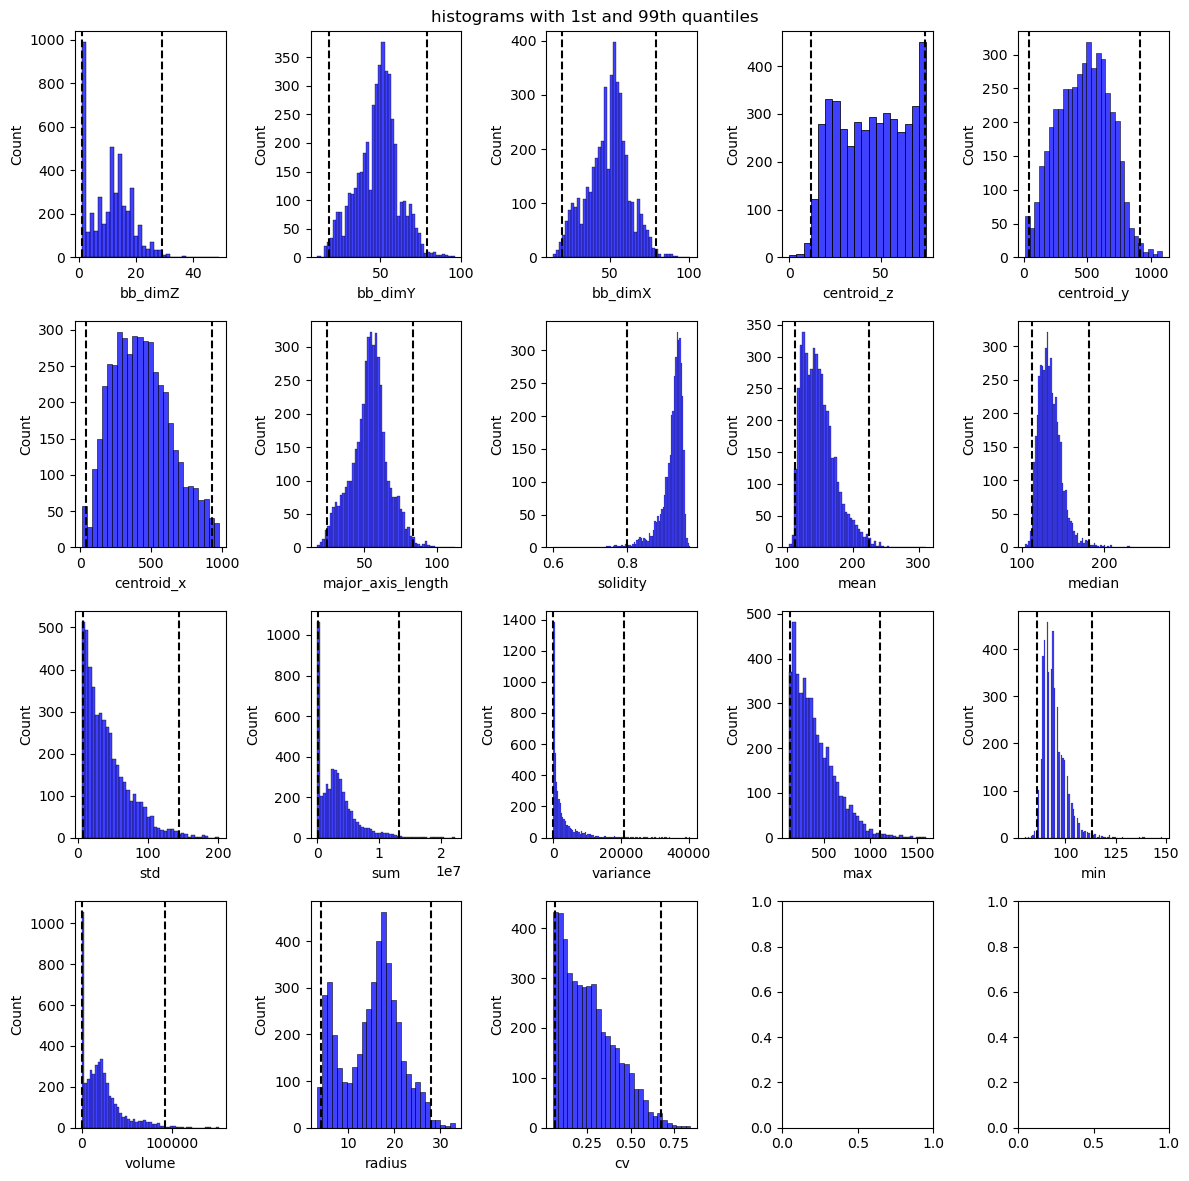

In [ ]:
quantitativeVars = ["bb_dimZ", "bb_dimY", "bb_dimX", "centroid_z", "centroid_y", "centroid_x", "major_axis_length", "" "solidity", "mean", "median", "std", "sum", "max", "min", "volume","radius","cv"]
histogramsOfVariables(filt,variables=quantitativeVars)

## Plot variables pairwise


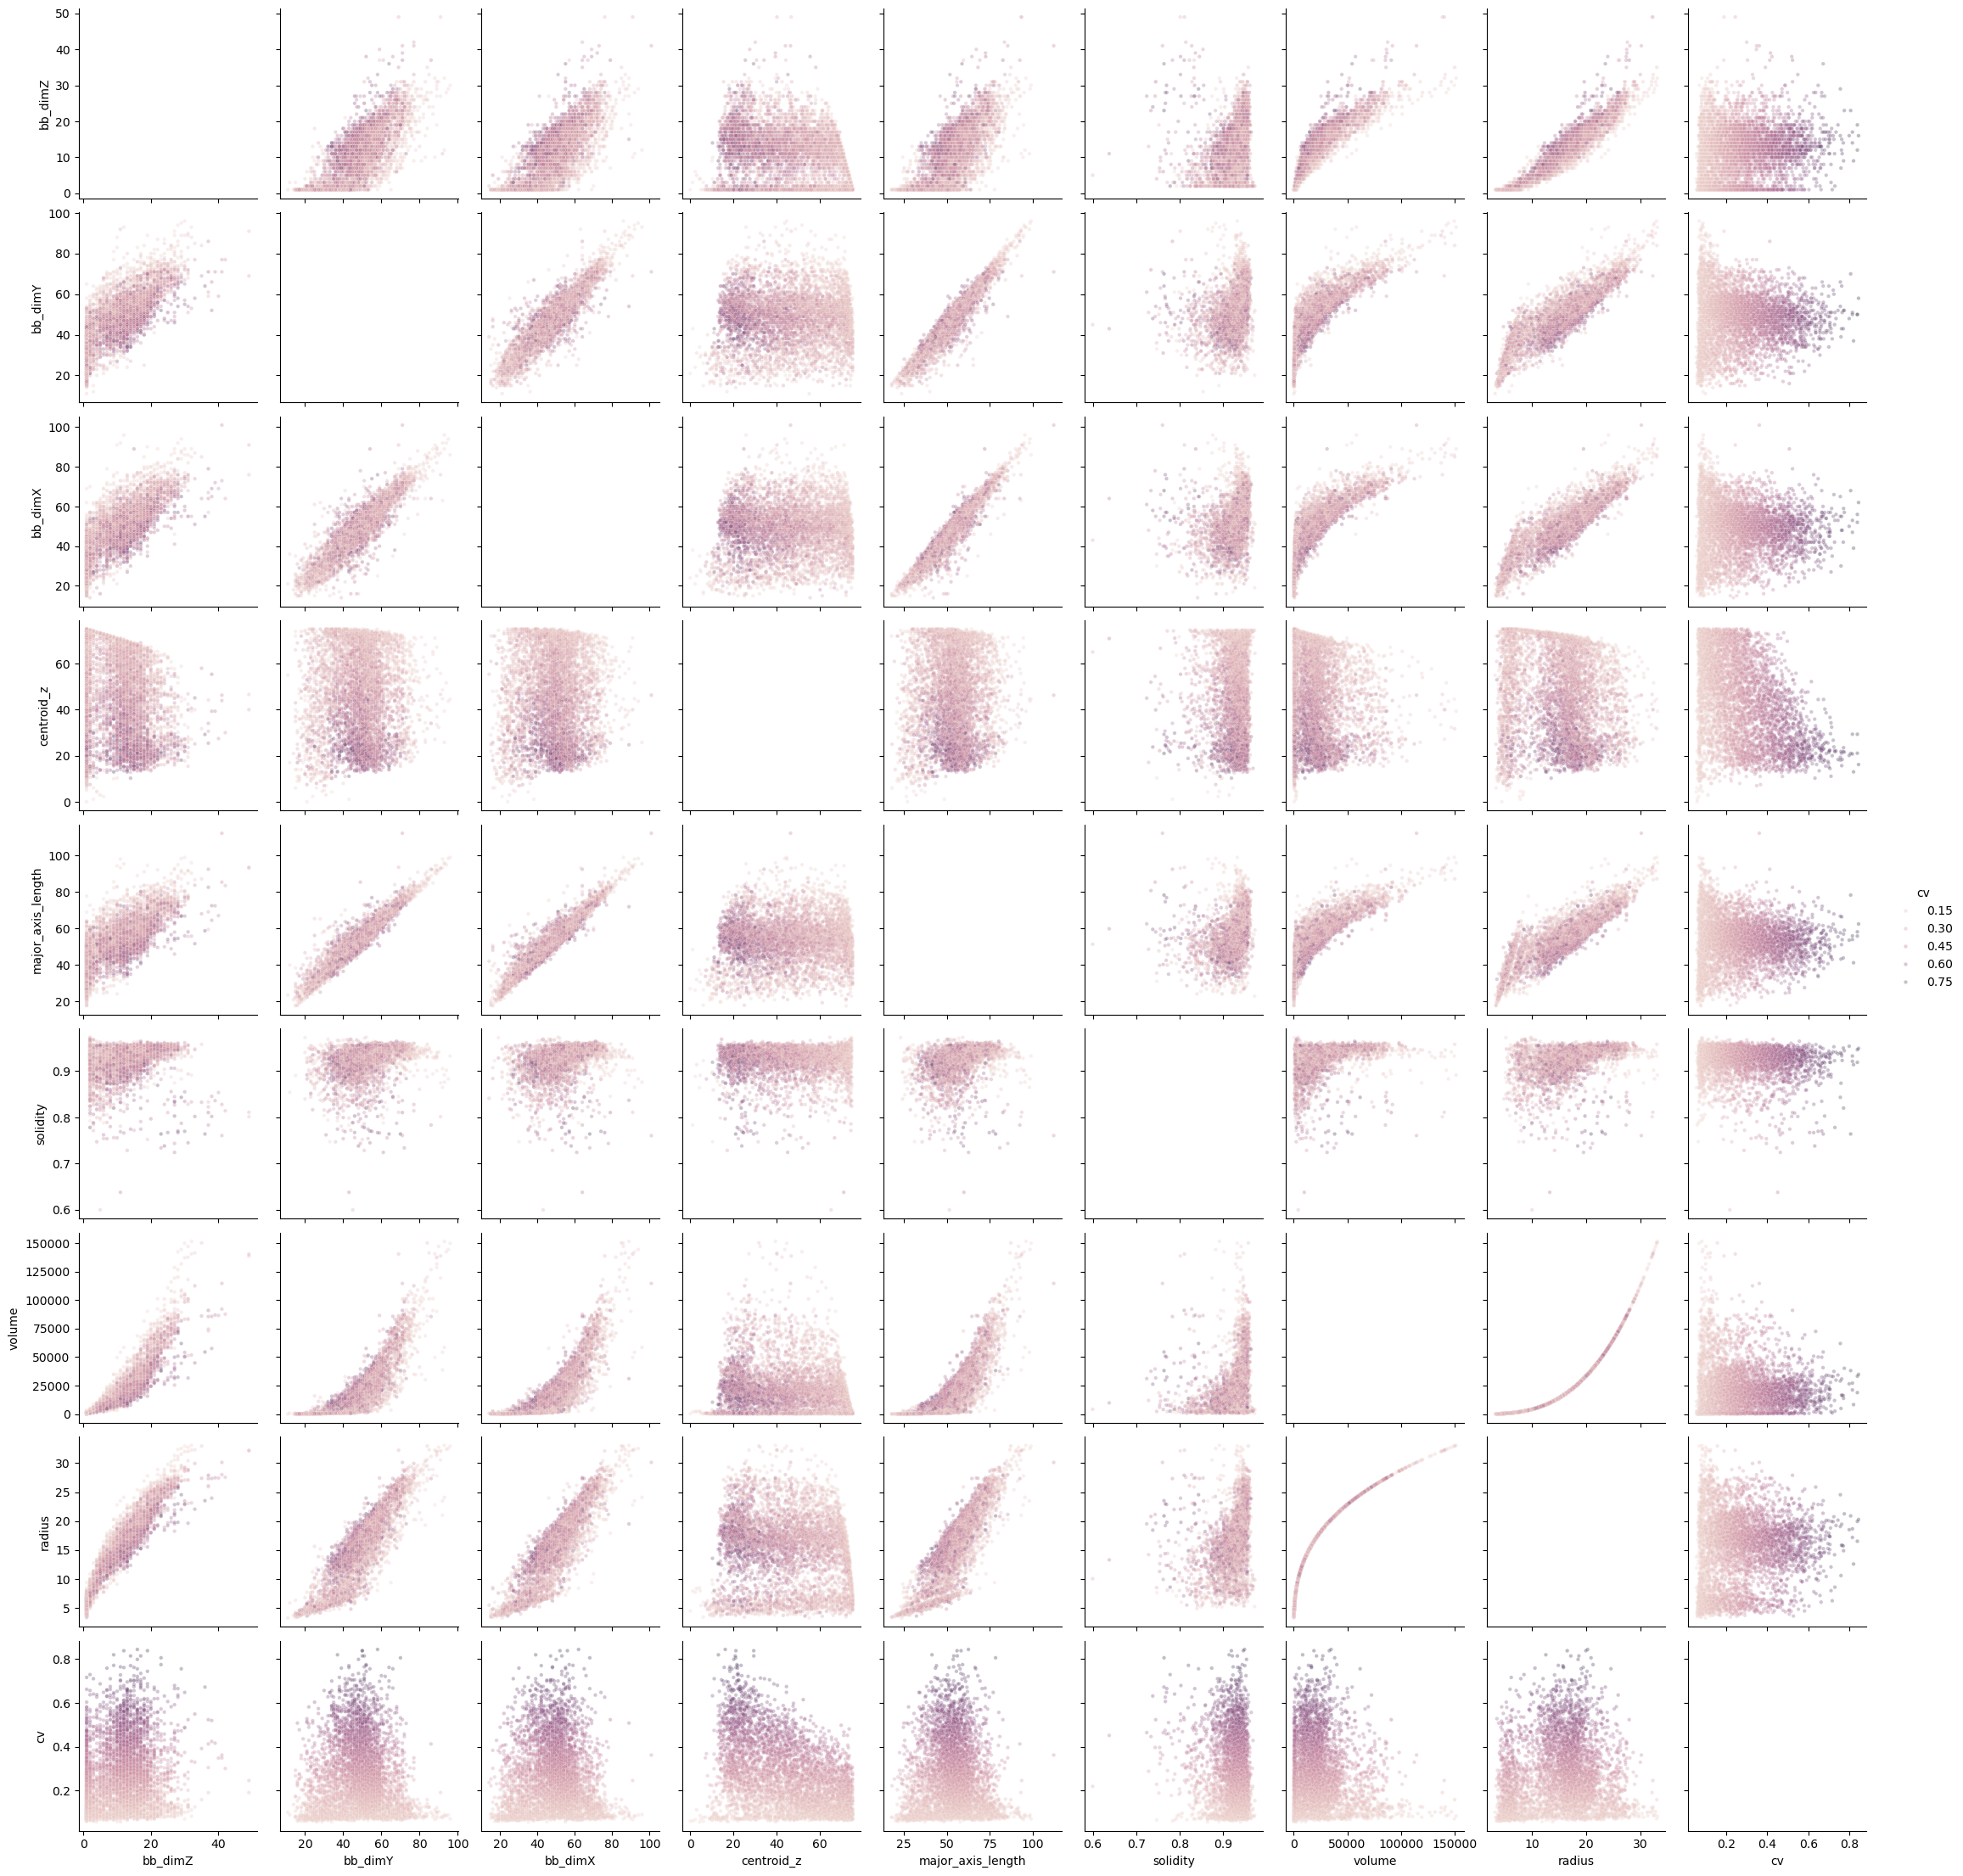

In [25]:

quantitativeVars = ["bb_dimZ", "bb_dimY", "bb_dimX", "centroid_z", "major_axis_length", "solidity", "volume", "radius", "cv"]
sns.pairplot(data=filt, vars=quantitativeVars, hue='cv', plot_kws={'alpha':0.3,'s':10})
plt.show()



In [30]:
quantitativeVars = [ "major_axis_length", "solidity", "volume", "radius", "mean", "median", "std", "variance", "cv"]
sns.pairplot(data=filt, vars=quantitativeVars, plot_kws={'alpha':0.3,'s':10}, hue='cv')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [71]:
filt.head()

label  bb_dimZ  bb_dimY  bb_dimX  centroid_z  centroid_y  centroid_x  \
1      2       13       51       48   17.092244  602.730192  235.823937   
2      3       24       48       58   23.818743  465.149410  405.504229   
3      4       13       47       42   17.885833  526.404655  261.189650   
4      5       10       47       50   16.749367  537.583875  332.809957   
5      6        9       44       45   16.197679  570.622426  414.887215   

   major_axis_length  solidity        mean  ...  protein  \
1          48.632410  0.728521  213.400834  ...    DPY27   
2          59.554474  0.738189  227.012229  ...    DPY27   
3          47.890527  0.919311  208.377154  ...    DPY27   
4          50.926443  0.926797  179.198181  ...    DPY27   
5          47.014676  0.874448  213.524055  ...    DPY27   

                                        raw_filepath  \
1  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
2  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
3  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
4  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   
5  /mnt/external.data/MeisterLab/Dario/Imaging/DP...   

                                   denoised_filepath     radius        cv  \
1  /mnt/external.data/MeisterLab/Dario/Imaging/DP...  14.198535  0.287539   
2  /mnt/external.data/MeisterLab/Dario/Imaging/DP...  18.436575  0.631069   
3  /mnt/external.data/MeisterLab/Dario/Imaging/DP...  15.427610  0.557816   
4  /mnt/external.data/MeisterLab/Dario/Imaging/DP...  15.169897  0.520013   
5  /mnt/external.data/MeisterLab/Dario/Imaging/DP...  13.663074  0.640061   

   zx_ratio  zy_ratio  xy_ratio  \
1  0.270833  0.254902  0.941176   
2  0.413793  0.500000  1.208333   
3  0.309524  0.276596  0.893617   
4  0.200000  0.212766  1.063830   
5  0.200000  0.204545  1.022727   

                                         zproj_spots  \
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        zproj_nuclei  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14...  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
5  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[5 rows x 32 columns]

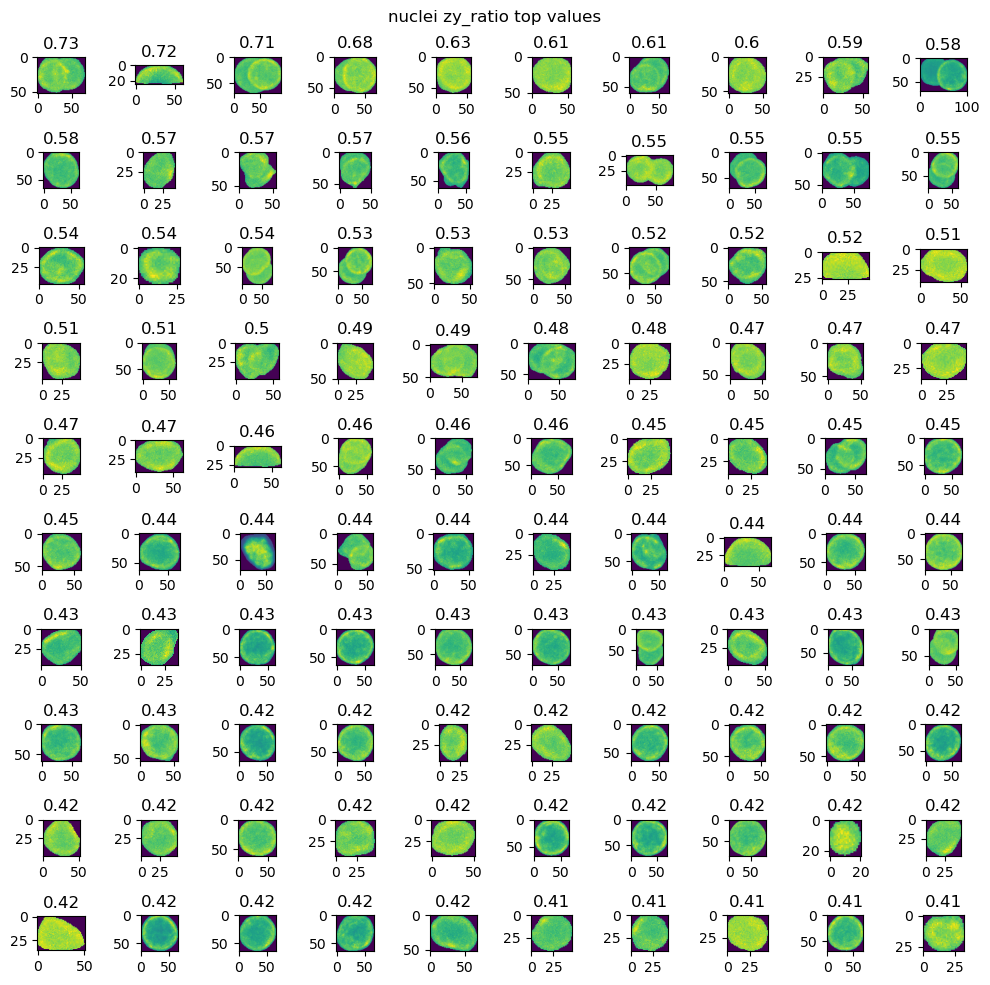

In [19]:
dataVar="zy_ratio"
nuclei=True
plot_nuclei_crop(filt, dataVar, top=True, nuclei=nuclei)

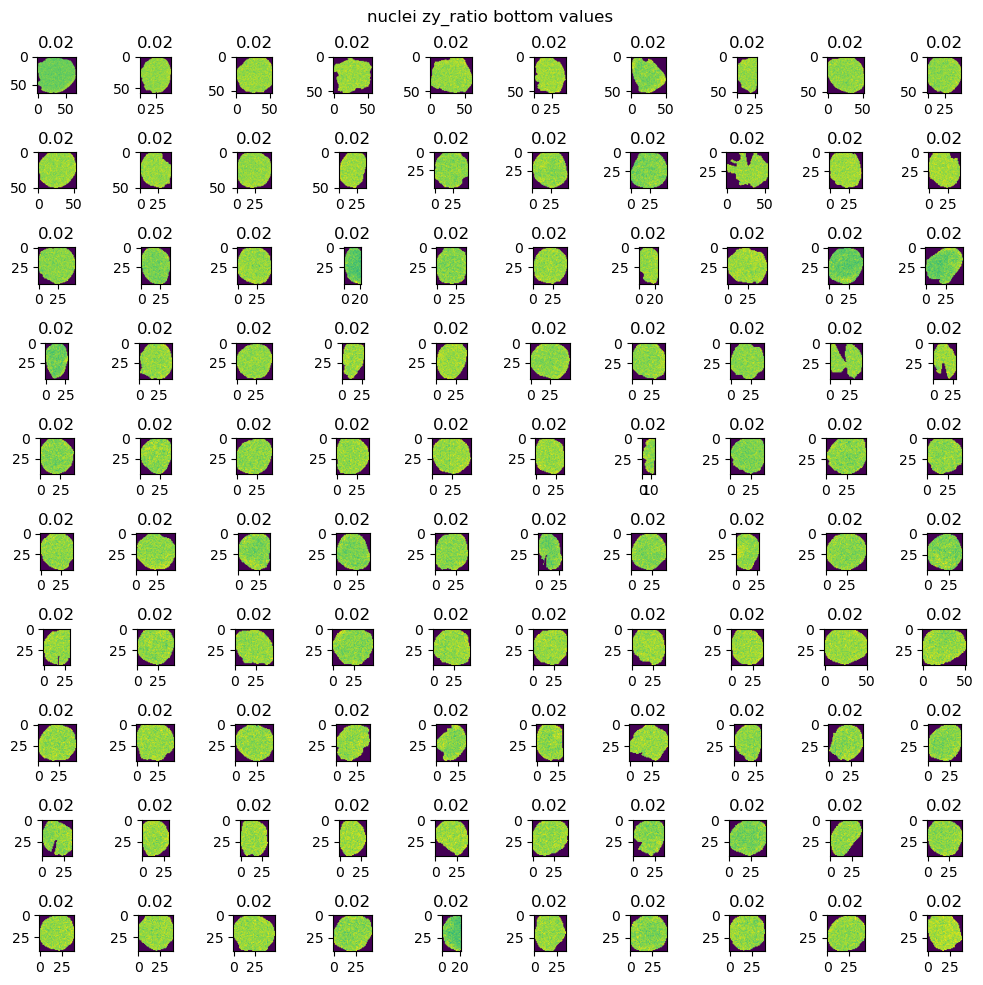

In [20]:
plot_nuclei_crop(filt, dataVar, top=False, nuclei=nuclei)

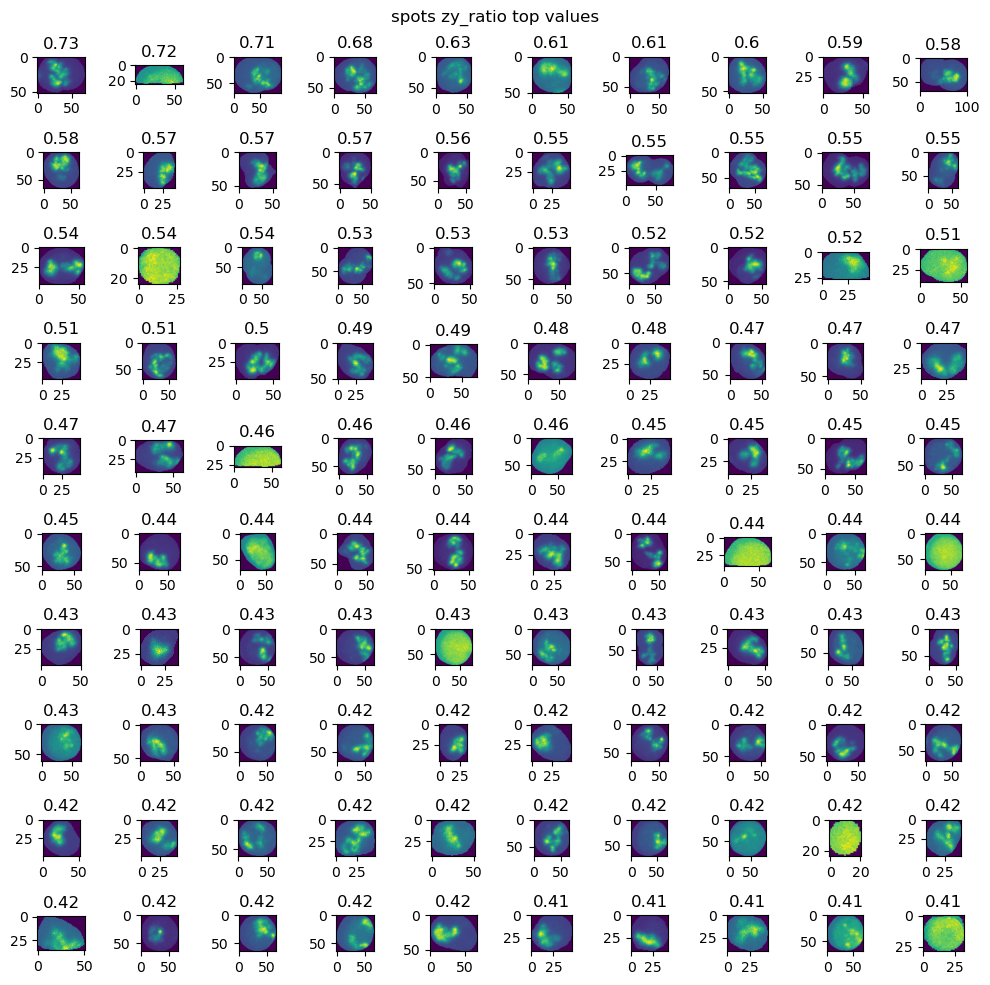

In [21]:
nuclei=False
plot_nuclei_crop(filt, dataVar, top=True, nuclei=nuclei)

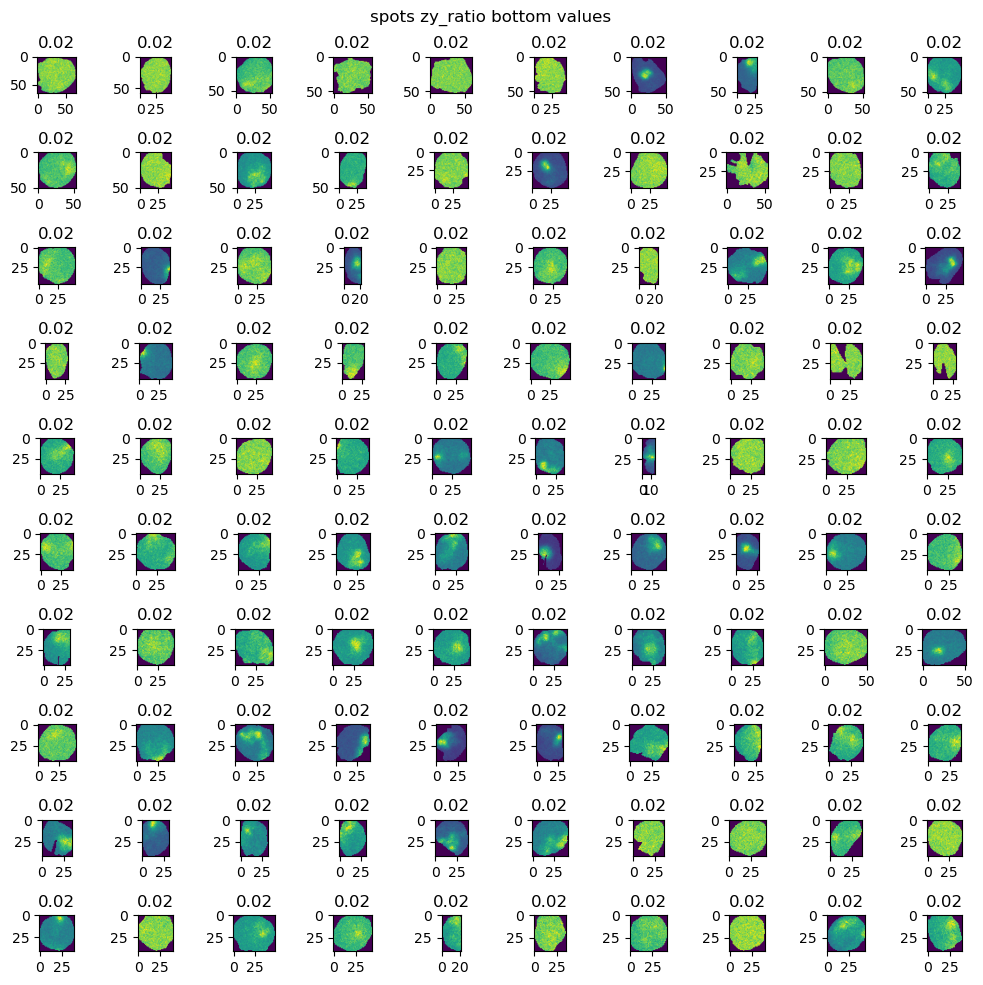

In [22]:
plot_nuclei_crop(filt, dataVar, top=False, nuclei=nuclei)

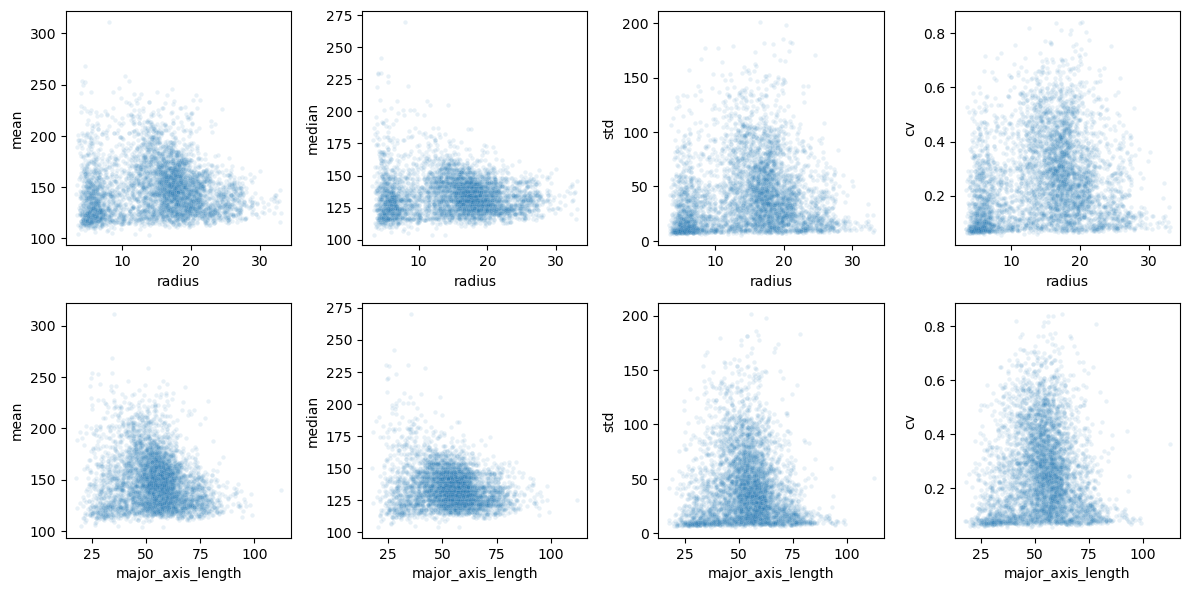

In [92]:
#filt=df[(df.solidity>0.85) & (df.major_axis_length<100) & (df.bb_dimZ>10) & (df.bb_dimZ<25) ] #& (df.centroid_z<40) & (df.centroid_z>20)]

xVars = ['radius', 'major_axis_length']
yVars = ['mean', 'median', 'std', 'cv']
fig, axs = plt.subplots(len(xVars), len(yVars), figsize=(12, 6))
for i in xVars:
    for j in yVars:
        sns.scatterplot(data=filt, x=i, y=j, ax=axs[xVars.index(i),yVars.index(j)], alpha=0.1, s=10)
plt.tight_layout()
plt.show()

#r, p = sp.stats.pearsonr(x=df['volume'], y=df['mean'])
#sns.regplot(data=filt, x="volume", y="mean", color='blue', ax=axs[0,0], robust=True, scatter_kws={'alpha':0.1,'s':10}, line_kws={'color':'red'})
#axs[0,0].text(2000, 250, 'r={:.2f}'.format(r))
#sns.regplot(data=filt, x="volume", y="median", color='blue', ax=axs[0,1], robust=True, scatter_kws={'alpha':0.1,'s':10}, line_kws={'color':'red'})
#sns.regplot(data=filt, x="volume", y="std", color='blue', ax=axs[1,0], robust=True, scatter_kws={'alpha':0.1,'s':10}, line_kws={'color':'red'})
#sns.regplot(data=filt, x="major_axis_length", y="cv", color='blue', ax=axs[1,1], robust=True, scatter_kws={'alpha':0.1,'s':10}, line_kws={'color':'red'})
#plt.show()

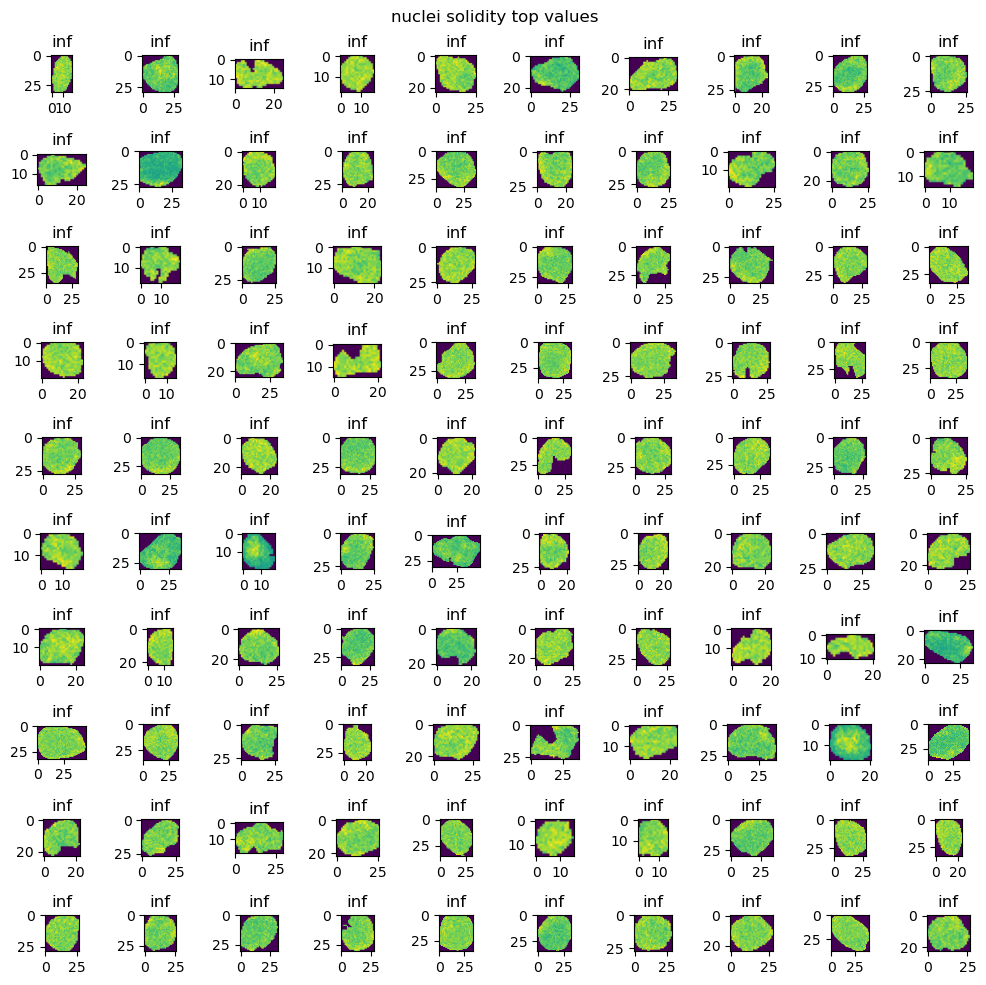

In [ ]:
dataVar="solidity"
top=True

plot_nuclei_crop(df, dataVar, dist, top=True, nuclei=True, display = True)

In [ ]:

plt.figure(figsize = (30,5),dpi = 300)
#plt.ylim((0,0.25e5))
violin_plot = sns.violinplot(data=df_filt, x="group", y="mass", inner=None)
for item in violin_plot.get_xticklabels():
    item.set_rotation(90)
violin_plot.tick_params(labelsize=10)
plt.title('Mean nuclear volume (in px^3) per group')